Autor: Jarosław Żygierewicz

Rozwiązanie: Zofia Hendrysiak

# Przygotowanie środowiska programistycznego.
W tym ćwiczeniu skorzystamy z modułu sklearn [scikit-learn](https://scikit-learn.org/stable/auto_examples/index.html) przeznaczonego do uczenia maszynowego. Zawiera wiele zoptymalizowanych i przydatnych funkcji i algorytmów. Alternatywnymi frameworkami są np. [PyTorch](https://pytorch.org/tutorials/), [Tensorflow](https://www.tensorflow.org/tutorials), [Keras](https://keras.io/examples/), [Caffe2](https://caffe2.ai/docs/tutorials), chociaż z obserwacji środowiska wynika, że dominują raczej PyTorch i Tensorflow.

In [ ]:
import sklearn
print('Zainstalowana wersja scikit-learn: {}.'.format(sklearn.__version__))

Zainstalowana wersja scikit-learn: 1.0.1.


Na stronie przedmiotu znajduje się instrukcja konfiguracji środowiska w przypadku pracy lokalnej, a nie w colabie. Może (nie musi) być przydatna dla osób pracujących na własnych laptopach:

https://brain.fuw.edu.pl/edu/index.php/Uczenie_maszynowe_i_sztuczne_sieci_neuronowe/konfiguracja

Zanim przejdziemy do właściwych zadań zaimportujmy potrzebne moduły:

In [ ]:
import numpy as np
from scipy import diag, interp
from itertools import cycle

from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

# Ćwiczenie: Walidacja krzyżowa
Już na ostatnich ćwiczeniach przerobiliśmy walidację krzyżową (ang. cross validation). Teraz przyjrzymy się jej bliżej i sprawdźmy efekt wspomniany na wykładzie, czyli efekt częstości występowania.

* W tym ćwiczeniu przyjrzymy się jak miary jakości klasyfikatora zależą od proporcji klas w zbiorze uczącym i od rozmiaru zbioru uczącego
* Klasyfikatorem będzie nadal regresja logistyczna, ale tym razem zamiast korzystać z własnej implementacji, skorzystamy z gotowej wersji bibliotecznej z modułu [scikit-learn] (http://scikit-learn.org/stable/index.html)


## Produkcja danych

Nasze przykłady będą należały do dwu klas: **0** lub **1**. Wartości zmiennych wejściowych $(x, y)$ dla danej klasy są dane dwuwymiarowym rozkładem Gaussa:

$$
p_{class~1}(x,y) = N(\mu_{class~1, x}, \mu_{class~1, y}, covariance)
$$

Proszę uzupełnić kod funkcji ```generate_class_points(nPoints, means, covariances, class)``` która zwraca macierz $(nPoints, 3)$ zawierającą położenia punktów danej klasy, oraz jej numer: (x,y,class)


* funkcja na wejściu przyjmuje liczbę przykładów do generacji $nPoints$, macierze $means$ i $covariance$ zawierające średnie i kowariancię dla danej klasy:

$$
means = [\mu_{x}, \mu_{y}]
$$

$$
covariance = 
\begin{bmatrix}
    \sigma^{2}_{x} & \sigma_{xy} \\
    \sigma_{xy} & \sigma^{2}_{y}
\end{bmatrix}   
$$

* liczbę kodującą numer klasy : $class$, w naszym przypadku ***0** lub **1**
 
 
Korzystając z funkcji  ```generate_class_points(nPoints, means, covariances)``` prosze wygenenerować po 10000 punktów dla dwu klas, dla których parametry rozkładów Gaussa są następujące:

```
means_class_1 = np.array([-1,0.5]) 
covariance_class_1 = np.diag([3,3]) 

means_class_2 = np.array([1.2,4]) 
covariance_class_2 = np.diag([4, 1.7]) 
```

Dane proszę załadować do obiektów pandas DataFrame dla każdej z klas, a następnie je połączyć korzystając z funkcji ```pandas.concatenate()```.

In [ ]:
def generate_class_data(nPoints, means, covariances, label):
    #Generacja własności - w naszym wypadku wartości (x,y) dla danej klasy
    features = np.random.multivariate_normal(means,covariances,nPoints)
    #Generacja macierzy z etykietami - tutaj numerem klasy
    labels = np.full((nPoints,1), label)
    #Połączenie macierzy dla własności i etykiet w jedną macierz
    class_data = np.concatenate((features, labels), axis=1)
    return class_data
    
nPoints = 10000    
    
#Defincja parametrów rozkładu Gaussa dla klasy "0"    
means_class_1 = np.array([-1,0.5]) 
covariance_class_1 =  np.diag([3,3]) 

#Definicja parametrów rozkładu Gaussa dla klasy "1"
means_class_2 = np.array([1.2,4]) 
covariance_class_2 = np.diag([4, 1.7]) 

#Generacja danych dla klas "0" i "1"
class_0_data = generate_class_data(nPoints, means_class_1, covariance_class_1, 0)
class_1_data = generate_class_data(nPoints, means_class_2, covariance_class_2, 1)

#Sprawdzenie czy wygenrowane dane mają poprawny kształt
print(class_0_data)
print(class_1_data)

#Utworzenie obiektu DataFrame dla klas "0" i "1"
df_class_0 = pd.DataFrame(class_0_data, columns = ["x","y","label"])
df_class_1 = pd.DataFrame(class_1_data, columns = ["x","y","label"])

#Utworzenie obiektu DataFrame dla odu klas lącznie
df = pd.concat([df_class_0, df_class_1], ignore_index=True)

#Wypisanie zawartości obiektu DataFrame dla odu klas lącznie
print(df)

[[ 1.14291898 -0.98379409  0.        ]
 [-0.56722267  0.24944859  0.        ]
 [-1.29532145  3.32901925  0.        ]
 ...
 [-0.41126801  0.51251952  0.        ]
 [-1.49505061  2.72919076  0.        ]
 [-0.55942976  0.66389518  0.        ]]
[[-0.18903726  4.78667785  1.        ]
 [ 2.45026049  5.91811822  1.        ]
 [ 0.68723079  3.25157243  1.        ]
 ...
 [ 3.75430485  6.79474215  1.        ]
 [ 1.44586574  5.5999061   1.        ]
 [-2.238952    4.77834536  1.        ]]
              x         y  label
0      1.142919 -0.983794    0.0
1     -0.567223  0.249449    0.0
2     -1.295321  3.329019    0.0
3     -0.904619  1.784796    0.0
4     -4.038691 -0.142825    0.0
...         ...       ...    ...
19995  1.044604  7.327130    1.0
19996  2.430714  2.500280    1.0
19997  3.754305  6.794742    1.0
19998  1.445866  5.599906    1.0
19999 -2.238952  4.778345    1.0

[20000 rows x 3 columns]


## Analiza wizualna danych. 

Pierwszy krok przy analizie danych z użyciem dowolnego algorytmu to ich inspekcja. Korzystając z metod klasy DataFrame proszę:
* narysować rozkłady wszystkich zmiennych wejściowych oddzielnie dla klas 0 i 1
* narysować wykres korelacji między zmiennymi wejściowymi dla klas 0 i 1 na jednym rysunku

**Wskazówka**: proszę użyć parametru "hue" funkcji sns.jointplot()

Oglądając rysunki proszę sprawdzić jakościowo czy:
* czy średnie wartości $x$ i $y$ są zgodne z założeniami? 
* czy krotnośc klas jest zgodna z założeniami?
* czy rozkłady dwuwymiarowe są zgodne z założeniem diagonalnej macierzy kowiariancji? 

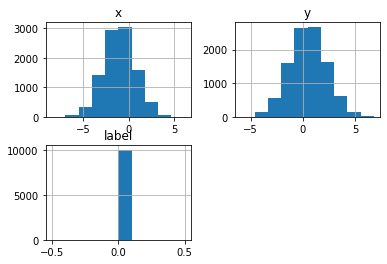

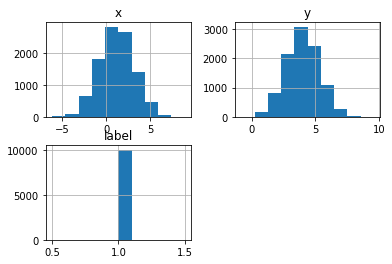

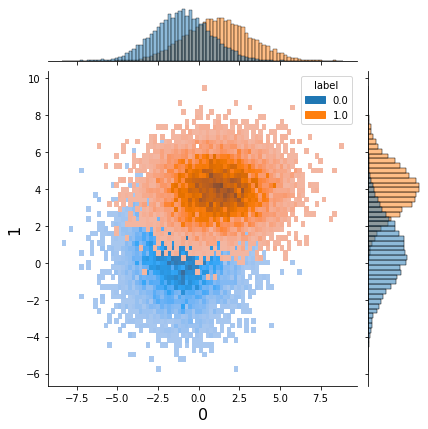

In [ ]:
#Histogramy rozkładów dla klasy "0"
df_class_0.hist()

#Histogramy rozkładów dla klasy "1"
df_class_1.hist()

#Dwuwymiarowy rozkład y vs x dla klasy "0" i 1"
x = sns.jointplot(x="x", y="y", data=df, kind='hist', hue="label")
x.set_axis_labels('0', '1', fontsize=16);

# Analiza dla klas równolicznych

* podziel pełne dane na podzbiory uczący (80% danych) i terningowy (20% danych). Wykonując podział zwróć uwagę na randomizację danych.
* narysuj dwuwymiarowe rozkłady dla zbiorów uczącego i treningowego i sprawdź wizulanie czy są różne. 

**Wskazówka:** do podziałów zbioru proszę użyć funkcji [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) podając obiekt DataFrame jako argument.

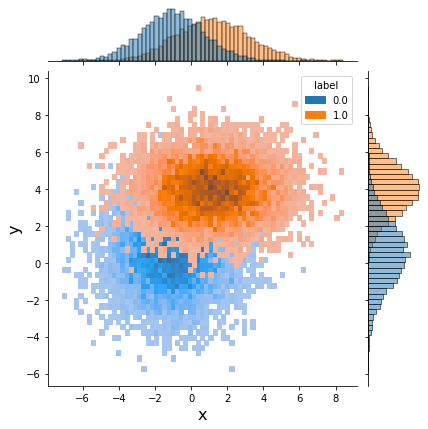

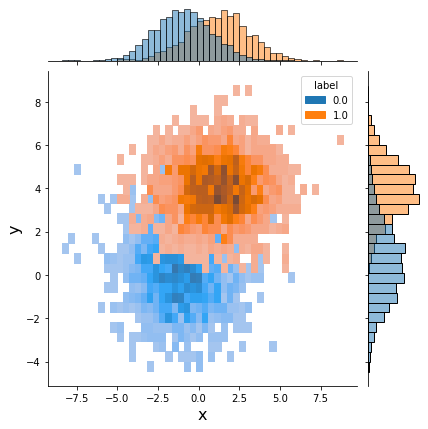

In [ ]:
#Podział danych na zbiory uczący i testowy
df_train, df_test = train_test_split(df, test_size=0.2)

#Dwuwymiarowy rozkład y vs x dla klasy "0" i 1" dla zbioru uczącego
x = sns.jointplot(x="x", y="y", data=df_train, kind='hist', hue="label")
x.set_axis_labels('x', 'y', fontsize=16);

#Dwuwymiarowy rozkład y vs x dla klasy "0" i 1" dla zbioru testowego
x = sns.jointplot(x="x", y="y", data=df_test, kind='hist', hue="label")
x.set_axis_labels('x', 'y', fontsize=16);

## Trening regresji logistycznej

Skorzystamy z implementacji regresji logistycznej z pakietu scikit-learn.
Regresja logistyczna zaimplementowana jest w klasie [`LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). 

* stwórz obiekt klasy ```LogisticRegression()```
* użyj tego obiektu by wytrenować model. W tym miejscu wykonają się kroki odpowiadające procedurze minimalizacji znajdującej parametry $\theta$ z zajęciach o regresji logistycznej
* przeprowadź predykcję na zbiorze testowym

**Wskazówka** domyślną funkcją minimalizacji jest 'lbfgs', ale warto ją podać explicite by uniknąć uciążliwego ostrzeżenia.

In [ ]:
#Definicja modelu - obiektu klasy LogisticRegression
model = LogisticRegression(solver = 'lbfgs')

#Przeprowadzenie minmalizacji lub dopasowania parametrów modelu (ang. fit)
model.fit(df_train[["x","y"]],df_train["label"])

#Przeprowadzenie predykcji (ang. predict)
y_pred = model.predict(df_test[["x","y"]])  

Oblicz macierz pomyłek (ang. confusion matrix)

* skorzystaj z funkcji ```metrics.confusion_matrix``` by wypisać wartości macierzy
* skorzystaj z funkcji ``` metrics.plot_confusion_matrix``` by narysować macierz pomyłek
* skorzystaj z funkcji ``` metrics.plot_confusion_matrix``` by narysować macierz pomyłek z wartościami znormalizowanymi względem liczby przykładów w prawdziwych klasach

**Pytanie**: jaką iterpretację mają elementy macierzy po normalizacji?

[[1786  221]
 [ 166 1827]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


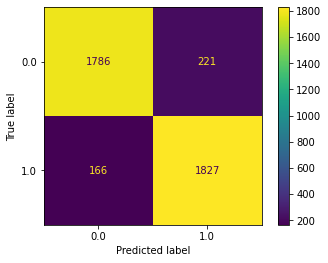

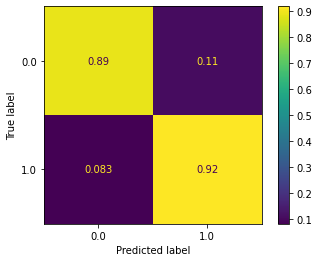

In [ ]:
#Wypisanie macierzy pomyłek w postaci tekstowej
print(metrics.confusion_matrix(df_test["label"], y_pred))

#Narysowanie macierzy pomyłek. 
metrics.plot_confusion_matrix(model, df_test[["x","y"]], y_true=df_test["label"])  

#Narysowanie macierzy pomyłek z normalizacją względem liczny przykładów w prawdziwych przykładów.
metrics.plot_confusion_matrix(model, df_test[["x","y"]], y_true=df_test["label"], normalize="true")  

Zbadajmy wartości różnych miar jakości:

* **precyzja pozytywna (positive predictive value (PPV), precision):**

$\qquad$ $PPV = \frac{TP}{P'}=\frac{TP}{ TP + FP}$

Ułamek przypadków oznaczonych jako klasa "1" który naprawdę należy do klasy "1". Ułamek ten jest np. odpowiedzą na pytanie
"Jeśli wynik testu jest pozytywny, jakie jest prawdopodobieństwo, że osoba badana jest chora?"

* **czułość: (ang. True Positive Rate, TPR, or recall):** 

$\qquad$ $TPR = \frac{TP}{ P} = \frac{TP} { TP+FN}$

Ułamek przypadków które należą do klasy "1" i został poprawnie oznaczony. Ułamek ten jest np. odpowiedzą na pytanie  "Jakie jest prawdopodobieństwo, że test wykonany dla osoby chorej wykaże, że jest ona chora?"


* **dokładność ( accuracy (ACC)):** Prawdopodobieństwo prawidłowej klasyfikacji.

$\qquad$ $ACC = \frac{TP + TN}{P + N}$

Ułamek przypadków, niezależnie od klasy, które zostały poprawnie oznaczone. Ułamek ten jest np. odpowiedzą na pytanie  "Jakie jest prawdopodobieństwo, że test poda poprawną odpowiedź?" 

* **F1-score:** średnia harmoniczna z precyzji i czułości:

$\qquad$ $F_1= 2 \frac{PPV  \cdot TPR}{PPV+TPR}= \frac{2TP}{ 2TP+FP+FN}$

Miara ta daje ocenę balansu między czułością a precyzją. Miara ta nie uwzględnia wyników prawdziwie negatywnych.

* **współczynnik korelacji Matthewsa ( Matthews correlation coefficient):**

$\qquad$ $
\text{MCC} = \frac{ TP \cdot TN - FP \cdot FN } {\sqrt{ (TP + FP) ( TP + FN ) ( TN + FP ) ( TN + FN ) } }
$

Współczynnik MMC uwzględnia wyniki zarówno prawdziwie jaki i fałszywie pozytywne i negatywne i jest na ogół uważany jako zrównoważona miara, która może być stosowana nawet wtedy, gdy klasy są bardzo różnej liczebności. 

MCC jest w istocie współczynnikiem korelacji pomiędzy obserwowanymi i przewidywanymi klasyfikacjami binarnymi; zwraca wartość od -1 do +1. 

* Współczynnik +1 odpowiada idealnej klasyfikacji, 
* 0 nie lepiej niż losowe przypisanie wyniku i 
* -1 oznacza całkowitą niezgodę między klasyfikacją  i stanem faktycznym.
 
***
 
Proszę uzupełnić funkcję ```calculate_metric(nIter)```, która:
* liczy powyższe wskaźniki powtarzając podziały próbki $nIter$ razy (za każdym razem losując od nowa
* zwraca macierz wartości miar, gdzie dla każdego wiersza mamy następujące znaczenie kolumn: $(PPV, TPR, ACC, F1, MCC)$. Macierz powinna więc mieć kształ (nIter, 5)

Korzystając z funkcji ```calculate_metric(nIter)``` proszę:
* obliczyć wartości parametrów dla 100 iteracji
* stworzyć obiekt DataFrame zawierający kolumny "PPV", "TPR", "ACC", "F1", "MCC"
* narysować rozkłady wartości miar jakości
* narysować rozkłady dokładności jako dane podając oryginalną próbkę i próbkę stanowiącą 10% oryginalnej

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.2 µs


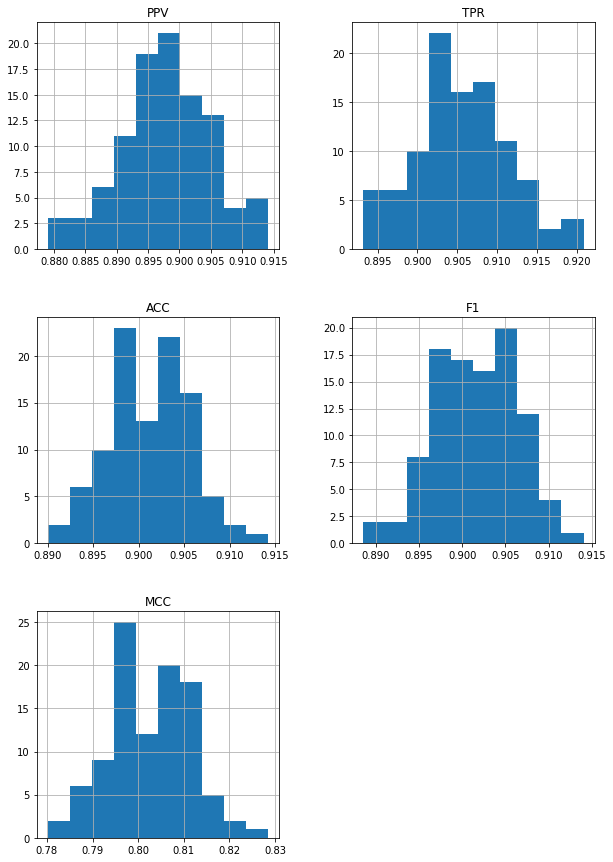

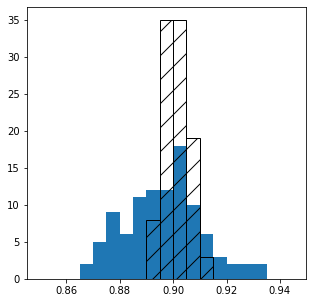

In [ ]:
%time
def calculate_metric(data, nIter):
    model = LogisticRegression(solver = 'lbfgs') 
    result = np.array([])
    #Pętla po kolejnych iteracjach procesu trenowania-testowania
    for i in range(nIter):
        #Podział próbki na części treningową i testową
        df_train, df_test = train_test_split(data, test_size=0.2)

        #Przeprowadzenie minmalizacji lub dopasowania parametrów modelu (ang. fit)
        model.fit(df_train[["x","y"]],df_train["label"])

        #Predykcja
        y_pred = model.predict(df_test[["x","y"]])  
        y_true = df_test["label"]
        #Obliczenie wartości miar jakości
        PPV = metrics.precision_score(y_true, y_pred)
        TPR = metrics.recall_score(y_true, y_pred)
        ACC = metrics.accuracy_score(y_true, y_pred)
        F1 = metrics.f1_score(y_true, y_pred)
        MCC = metrics.matthews_corrcoef(y_true, y_pred)
        #Spakowanie uzyskanych licz do jednej macierzy
        result = np.append(result, np.array([PPV, TPR, ACC, F1, MCC]), axis=0)
        
    result = np.reshape(result, (-1,5))  
    result = pd.DataFrame(result, columns = ["PPV", "TPR", "ACC", "F1", "MCC"])  
    return result     
  
#Obliczenie wartości metryk na pełnych danych    
metrics_data = calculate_metric(df, nIter=100)
#Przepakowanie uzyskanych liczb do obiektu DataFrame
df_metrics = pd.DataFrame(data=metrics_data, columns = ["PPV", "TPR", "ACC", "F1", "MCC"])
#Wyrysowanie histogramów dla wszystkich metryk
df_metrics.hist(figsize=(10,15))

#Obliczenie wartości metryk na 10% danych  
df_sample= df.sample(frac = 0.1)
df_metrics_10percent = calculate_metric(df_sample, nIter=100)


#Wyrysowanie rozkładu dokładności (ACC) dla obu zestawów danych 
axis = plt.figure(figsize=(5,5)).subplots(1, 1)
df_metrics_10percent["ACC"].hist(ax = axis, bins=np.arange(0.85, 0.95, 0.005), grid=False)
df_metrics["ACC"].hist(ax=axis,  bins=np.arange(0.85, 0.95, 0.005), fill=False, hatch="/", grid=False)

Jaka jest zależność rozrzutu wyniku metryki od rozmiaru próbki?

Proszę postawić jakąś hipotezę, a potem uruchomić poniższą komórkę. Czy wykresy zgadzają się z hipotezą?

**Uwaga:** wykonanie kodu może zająć kilka minut.

CPU times: user 53.3 s, sys: 25.8 s, total: 1min 19s
Wall time: 50.6 s


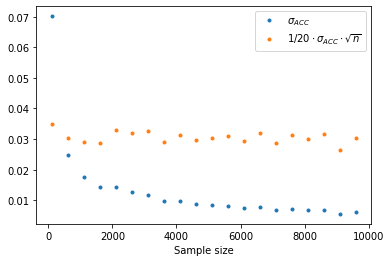

In [ ]:
%%time
def evaluate_std(nEvents, nIter):
    metrics_data = calculate_metric(df.sample(nEvents), nIter=nIter) 
    df_metrics = pd.DataFrame(data=metrics_data, columns = ["PPV", "TPR", "ACC", "F1", "MCC"])
    return df_metrics["ACC"].std()

nIter = 100
sampleSizes = np.arange(100,10000,500)
std_values = [evaluate_std(nEvents, nIter) for nEvents in sampleSizes]

plt.plot(sampleSizes, std_values, ".", label = r"$\sigma_{ACC}$")
plt.plot(sampleSizes, std_values*np.sqrt(sampleSizes)/20, ".", label=r"$1/20 \cdot \sigma_{ACC} \cdot \sqrt{n}$")
plt.xlabel("Sample size")
plt.legend()

W czasier analizy wydajności modelu zwykle stosuje się modyfikację losowego podziału na dane treningowe i testowe. Całe dane są dzielone na
równych k podziałów (ang. folds) i jest przeprowadzana k-krotna procedura sprawdzania (ang. k-fold cross-validation):

0. dzielimy zbiór uczący (features, labels) na `k` równych części
1. odkładamy i-tą, i=(0,1,2,3,...,k-1), część jako dane testowe, 
2. na pozostałych `k-1` częściach uczymy klasyfikator
3. obliczamy miary jakości na tej odłożonej części
4. wracamy do punktu 1
5. na końcu mozna policzyć wartości metryk uśrednione po podziałach

Procedura sprawdzania metryk z użyciem "k-fold cross-validation" jest zaimplementowana w pakiecie `sklearn` przez funkcję [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html).

Funkcja ```print_k_cv_scores(data, model)``` wypisuje na ekran wartości metryk. Funkcja przyjmuje na wejściu:
* obiekt DataFrame reprezentujący dane
* model z pakietu  `sklearn` reprezentujący model do wytrenowania (w naszym przypadku `LogisticRegression`)

Uzupełnij funkcję 'cross_val_score' by wypisywała wartości dla metryk ```['precision','recall','accuracy','f1']```

In [ ]:
#Dodajemy metrykę MCC do listy fukncji oceniających
metrics.SCORERS['mcc'] = make_scorer(metrics.matthews_corrcoef)

def print_k_cv_scores(data, model):
    #Lista z nazwami metryk rozpoznawanymi przez funkcję cross_val_score
    metric_names = ['precision','recall','accuracy','f1','mcc']
    #Pętla po metrykach do policzenia
    for metric_name in metric_names:
        #Obliczenie wartości metryki
        value = cross_val_score(model, data[["x","y"]], data["label"], cv=5, scoring=metric_name)
        print(metric_name.capitalize()+' = {0:.2f} +/- {1:.2f}'.format(value.mean(),value.std()))
        
#Wołamy funkcję wypisującą wartości metryk        
print_k_cv_scores(df, model)

Precision = 0.90 +/- 0.01
Recall = 0.91 +/- 0.00
Accuracy = 0.90 +/- 0.00
F1 = 0.90 +/- 0.00
Mcc = 0.80 +/- 0.00


Metryki pokazują wydajność klasyfikatora dla ustalonego progu klasyfikacji: p>50% -> klasa 1.
Zbadajmy jak wyglądają krzywe ROC dla poszczególnych podziałów, oraz dla sumy podziałów. 

Funkcja ```plot_ROC(data)``` rysuje krzywe ROC dla poszczególnych podziałów, oraz wypisuje dla nich wartości metryk. Funkcja korzysta z obiektu
[StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) który zwaraca indeksy elementów należących do zbiorów uczącego i testowego. Funkcja przyjmuje argumenty:
* data - obiekt DataFrame zawierający analizowane dane 

Proszę uzupełnić kod funkcji ```plot_ROC(data)```

Fold number: 0
Precision = 0.90 +/- 0.01
Recall = 0.91 +/- 0.00
Accuracy = 0.90 +/- 0.00
F1 = 0.90 +/- 0.00
Mcc = 0.80 +/- 0.00
None
Fold number: 1
Precision = 0.90 +/- 0.01
Recall = 0.91 +/- 0.00
Accuracy = 0.90 +/- 0.00
F1 = 0.90 +/- 0.00
Mcc = 0.80 +/- 0.00
None
Fold number: 2
Precision = 0.90 +/- 0.01
Recall = 0.91 +/- 0.00
Accuracy = 0.90 +/- 0.00
F1 = 0.90 +/- 0.00
Mcc = 0.80 +/- 0.00
None
Fold number: 3
Precision = 0.90 +/- 0.01
Recall = 0.91 +/- 0.00
Accuracy = 0.90 +/- 0.00
F1 = 0.90 +/- 0.00
Mcc = 0.80 +/- 0.00
None
Fold number: 4
Precision = 0.90 +/- 0.01
Recall = 0.91 +/- 0.00
Accuracy = 0.90 +/- 0.00
F1 = 0.90 +/- 0.00
Mcc = 0.80 +/- 0.00
None


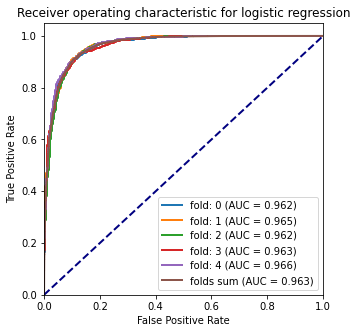

In [ ]:
from termcolor import colored

def plot_ROC(data, assignAllToClass1 = False):
    #Tworzymy obiekt wykonujący podziały próbki
    skf  = StratifiedKFold(n_splits=5)
    #Definiujemy model który będzie optymalizowany
    model = LogisticRegression(solver = 'lbfgs')
    #Przygotowujemy pole do rysowania
    plt.figure(figsize=(5,5))
    #Licznik podziałów
    foldNumber=0
    #Macierze przechowujące wyniki dla poszczególnych podziałóww
    y_pred_sum = np.array([])
    y_true_sum = np.array([])

    for train_indices, test_indices in skf.split(data, data["label"]):
        #Tworzymy zbiory uczący i testowy
        df_train = data.reindex(train_indices).dropna()
        df_test = data.reindex(test_indices).dropna()

        #Przeprowadzenie minmalizacji lub dopasowania parametrów modelu (ang. fit)
        model.fit(df_train[["x","y"]],df_train["label"])

        #Predykcja
        y_pred = model.predict(df_test[["x","y"]])  
        y_true = df_test["label"]
        #Wypisujemy wartości metryk dla na zbiorze testowym
        print(colored("Fold number:","red"),foldNumber)
        print(print_k_cv_scores(df, model))
        PPV = metrics.precision_score(y_true, y_pred)
        TPR = metrics.recall_score(y_true, y_pred)
        ACC = metrics.accuracy_score(y_true, y_pred)
        F1 = metrics.f1_score(y_true, y_pred)
        MCC = metrics.matthews_corrcoef(y_true, y_pred)
        #Obliczamy wynik działania modelu (=prawdopodobieństwo przynależności do klas "0" i "1")
        y_pred = model.predict_proba(df_test[["x","y"]])
        if assignAllToClass1:
            pass 
        #Wybieramy prawdopodobieństwo przynależności do klasy "1"
        y_pred = y_pred[:,1] 
        #Dołączamy wyniki dla danego podziału do macierzy przechowujących dane dla wszyskich podziałów
        y_pred_sum = np.append(y_pred_sum, y_pred)
        y_true_sum = np.append(y_true_sum, df_test["label"])
        #Obliczamy dane dla krzywej ROC
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        roc_auc = auc(fpr, tpr)
        #Obliczamy powierzchnię pod krzywą ROC
        
        #Rysujemy krzywą ROC
        plt.plot(fpr, tpr, lw=2, label="fold: {:d} (AUC = {:0.3f})".format(foldNumber, roc_auc))
        foldNumber+=1
    #Obliczamy i rysujemy krzywą ROC dla sumy podziałów
    fpr, tpr, thresholds = roc_curve(y_true_sum, y_pred_sum)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label="folds sum (AUC = {:0.3f})".format(roc_auc))
    #Dodajemy krzywą ROC losowego klasyfikatora.
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for logistic regression')
    plt.legend(loc="lower right")
    plt.show()   

#Wołamy funkcję do rysowania.    
plot_ROC(data=df)   

Podobnie jak to było w przypadku losowego podziału możemy sprawdzić jak wyniki zależą od rozmiaru zbioru uczącego. Funkcja ```evaluate_metris_with_cross_validation(nEvents, metric_name)``` tworzy obiekt DataFrame zawierający średnią i odchylenie standardowe metryki dla obliczone dla podziałów. Proszę przeanalizować rysunki i odpowiedzieć na pytanie:

* która metryka wyróżnia się spośród pozostałych?
* jak zmienia się odchylenie standardowe metryk względem rozmiaru próbki? Proszę zmodyfikować kod by zweryfikować swoją hipotezę.
* jaką wadę ma metryka MCC?

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 5.48 µs


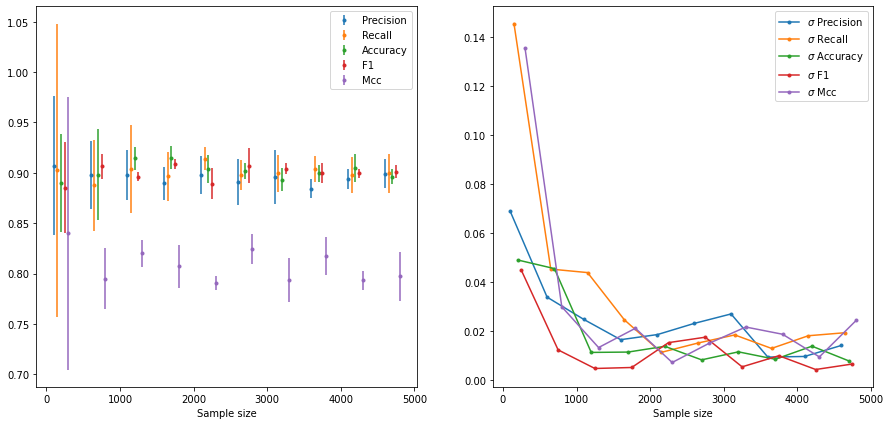

In [ ]:
%time
def evaluate_metris_with_cross_validation(nEvents, metric_name):
    df_train = df.sample(nEvents)
    value = cross_val_score(model, df_train[["x","y"]], df_train["label"], cv=5, scoring=metric_name)
    return np.array([value.mean(), value.std()])


_, axes = plt.subplots(1, 2, figsize=(15, 7))

metric_names = ['precision','recall','accuracy','f1',"mcc"]
sampleSizes = np.arange(100,5000,500)
for metric_index, metric_name in enumerate(metric_names):
    scores = np.array([evaluate_metris_with_cross_validation(nEvents, metric_name) for nEvents in sampleSizes])
    axes[0].errorbar(sampleSizes+50*metric_index, scores[:,0], linestyle="None", yerr = scores[:,1], marker=".",label = metric_name.capitalize());
    axes[1].plot(sampleSizes+50*metric_index, scores[:,1], marker=".",label = r"$\sigma$ "+metric_name.capitalize());

axes[0].set_xlabel("Sample size")
axes[0].legend();

axes[1].set_xlabel("Sample size")
axes[1].legend();

# Analiza dla klas niezrównoważonych.

Do tej pory liczebnośc obu klas w analizowanych danych była równa. Korzystając z początkowych zbiorów `class_0_data` oraz `class_1_data` stwórz zbiór w którym klasy nie bedą równoliczne i klasa "1" jest 100 razy bardziej liczba niż klasa "0".

**Wskazówka**: stwórz nowy obiekt DataFrame z danych dkal klas "0" i "1", ale dobierz próbkowanie danych dkla poszczególnych klas, tak by w sumarycznym zbiorze klasa "1" była 100 razy bardziej liczba niż klasa "0".

In [ ]:
class_0_data = pd.DataFrame(class_0_data).sample(frac = 0.01)

df_non_equal = df = pd.concat([df_class_0, df_class_1], ignore_index=True)
print(df_non_equal)

              x         y  label
0      1.142919 -0.983794    0.0
1     -0.567223  0.249449    0.0
2     -1.295321  3.329019    0.0
3     -0.904619  1.784796    0.0
4     -4.038691 -0.142825    0.0
...         ...       ...    ...
19995  1.044604  7.327130    1.0
19996  2.430714  2.500280    1.0
19997  3.754305  6.794742    1.0
19998  1.445866  5.599906    1.0
19999 -2.238952  4.778345    1.0

[20000 rows x 3 columns]


Korzystając z metod klasy DataFrame proszę:
* narysować rozkłady wszystkich zmiennych wejściowych oddzielnie dla klas 0 i 1
* narysować wykres korelacji między zmiennymi wejściowymi oddzielnie dla klas 0 i 1

**Wskazówka**: 
* proszę użyć filtrowania obiektu DataFrame
* proszę użyć parametru "hue" funkcji sns.jointplot()

Oglądając rysunki proszę sprawdzić jakościowo:
* czy krotności klas są zgodne z założeniami?

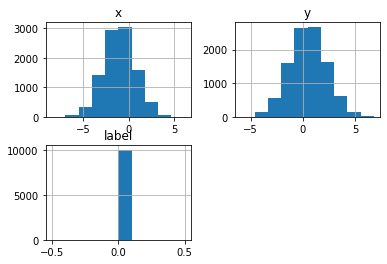

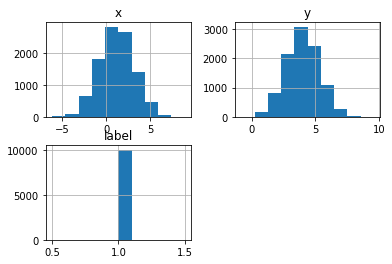

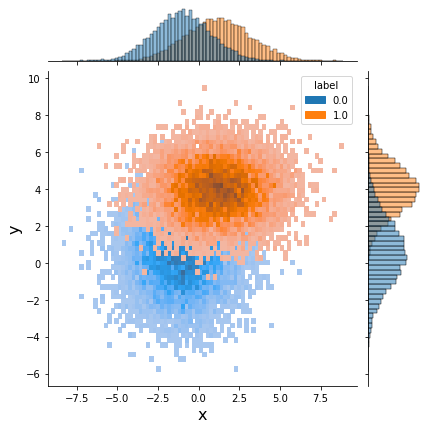

In [ ]:
#Histogramy rozkładów dla klasy "0"
df_class_0.hist()

#Histogramy rozkładów dla klasy "1"
df_class_1.hist()

#Dwuwymiarowy rozkład y vs x dla klasy "0" i 1"
x = sns.jointplot(x="x", y="y", data=df, kind='hist', hue="label")
x.set_axis_labels('x', 'y', fontsize=16);

Korzystając z funkcji ```plot_ROC(data)``` wypisz na ekran wartości miar, oraz narysuje krzywe ROC dla danych niezrównoważonych.

Fold number: 0
Precision = 0.90 +/- 0.01
Recall = 0.91 +/- 0.00
Accuracy = 0.90 +/- 0.00
F1 = 0.90 +/- 0.00
Mcc = 0.80 +/- 0.00
None
Fold number: 1
Precision = 0.90 +/- 0.01
Recall = 0.91 +/- 0.00
Accuracy = 0.90 +/- 0.00
F1 = 0.90 +/- 0.00
Mcc = 0.80 +/- 0.00
None
Fold number: 2
Precision = 0.90 +/- 0.01
Recall = 0.91 +/- 0.00
Accuracy = 0.90 +/- 0.00
F1 = 0.90 +/- 0.00
Mcc = 0.80 +/- 0.00
None
Fold number: 3
Precision = 0.90 +/- 0.01
Recall = 0.91 +/- 0.00
Accuracy = 0.90 +/- 0.00
F1 = 0.90 +/- 0.00
Mcc = 0.80 +/- 0.00
None
Fold number: 4
Precision = 0.90 +/- 0.01
Recall = 0.91 +/- 0.00
Accuracy = 0.90 +/- 0.00
F1 = 0.90 +/- 0.00
Mcc = 0.80 +/- 0.00
None


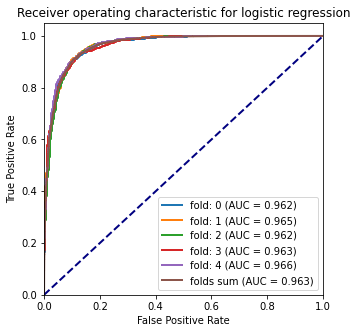

In [ ]:
plot_ROC(df_non_equal)

Powyższe obliczenia obliczenia proszę przeprowadzić dla klas, których rozkłady wyraźnie się różnią i dla takich które się pokrywają w znacznym stopniu. Proszę stworzyć nowe zestawy danych dla przypadków:

* kiedy rozkłady (x,y) dla klas "0" i "1" są bardzo podobne - klasy są trudno rozróznialne

I wypisać dla nich wartości metryk oraz narysować krzywe ROC dla niezrównoważonych zbiorów w których klasa "1" jest 100 razy bardzije liczba niż klasa "0".

Fold number: 0
Precision = 0.90 +/- 0.01
Recall = 0.91 +/- 0.00
Accuracy = 0.90 +/- 0.00
F1 = 0.90 +/- 0.00
Mcc = 0.80 +/- 0.00
None
Fold number: 1
Precision = 0.90 +/- 0.01
Recall = 0.91 +/- 0.00
Accuracy = 0.90 +/- 0.00
F1 = 0.90 +/- 0.00
Mcc = 0.80 +/- 0.00
None
Fold number: 2
Precision = 0.90 +/- 0.01
Recall = 0.91 +/- 0.00
Accuracy = 0.90 +/- 0.00
F1 = 0.90 +/- 0.00
Mcc = 0.80 +/- 0.00
None
Fold number: 3
Precision = 0.90 +/- 0.01
Recall = 0.91 +/- 0.00
Accuracy = 0.90 +/- 0.00
F1 = 0.90 +/- 0.00
Mcc = 0.80 +/- 0.00
None
Fold number: 4
Precision = 0.90 +/- 0.01
Recall = 0.91 +/- 0.00
Accuracy = 0.90 +/- 0.00
F1 = 0.90 +/- 0.00
Mcc = 0.80 +/- 0.00
None


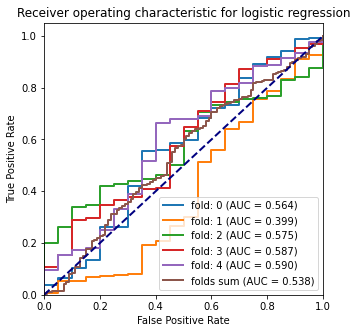

In [ ]:
nPoints = 10000    
    
#Defincja parametrów rozkładu Gaussa dla klasy "0"    
means_class_1 = np.array([-1,0.5]) 
covariance_class_1 =  np.diag([3,3]) 

#Definicja parametrów rozkładu Gaussa dla klasy "1"
means_class_2 = np.array([-1,0.5]) 
covariance_class_2 = np.diag([3, 3]) 

#Generacja danych dla klas "0" i "1"
class_0_data = generate_class_data(100, means_class_1, covariance_class_1, 0)
class_1_data = generate_class_data(nPoints, means_class_2, covariance_class_2, 1)
df_class_0 = pd.DataFrame(class_0_data, columns = ["x","y","label"])
df_class_1 = pd.DataFrame(class_1_data, columns = ["x","y","label"])

#Utworzenie obiektu DataFrame dla odu klas lącznie
df_non_separable = pd.concat([df_class_0, df_class_1], ignore_index=True)

plot_ROC(df_non_separable)

Powyższe obliczenia obliczenia proszę przeprowadzić dla klas, których rozkłady wyraźnie się różnią i dla takich które się pokrywają w znacznym stopniu. Proszę stworzyć nowe zestawy danych dla przypadków:

* kiedy rozkłady (x,y) dla klas "0" i "1" są bardzo podobne - klasa są łatwo separowalne

I wypisać dla nich wartości metryk oraz narysować krzywe ROC dla niezrównoważonych zbiorów w których klasa "1" jest 100 razy bardziej liczba niż klasa "0".

Fold number: 0
Precision = 0.90 +/- 0.01
Recall = 0.91 +/- 0.00
Accuracy = 0.90 +/- 0.00
F1 = 0.90 +/- 0.00
Mcc = 0.80 +/- 0.00
None
Fold number: 1
Precision = 0.90 +/- 0.01
Recall = 0.91 +/- 0.00
Accuracy = 0.90 +/- 0.00
F1 = 0.90 +/- 0.00
Mcc = 0.80 +/- 0.00
None
Fold number: 2
Precision = 0.90 +/- 0.01
Recall = 0.91 +/- 0.00
Accuracy = 0.90 +/- 0.00
F1 = 0.90 +/- 0.00
Mcc = 0.80 +/- 0.00
None
Fold number: 3
Precision = 0.90 +/- 0.01
Recall = 0.91 +/- 0.00
Accuracy = 0.90 +/- 0.00
F1 = 0.90 +/- 0.00
Mcc = 0.80 +/- 0.00
None
Fold number: 4
Precision = 0.90 +/- 0.01
Recall = 0.91 +/- 0.00
Accuracy = 0.90 +/- 0.00
F1 = 0.90 +/- 0.00
Mcc = 0.80 +/- 0.00
None


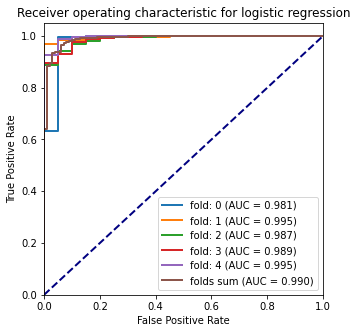

In [ ]:
nPoints = 10000    
    
#Defincja parametrów rozkładu Gaussa dla klasy "0"    
means_class_1 = np.array([-1,0.5]) 
covariance_class_1 =  np.diag([3,3]) 

#Definicja parametrów rozkładu Gaussa dla klasy "1"
means_class_2 = np.array([5,0.5]) 
covariance_class_2 = np.diag([3, 3]) 

#Generacja danych dla klas "0" i "1"
class_0_data = generate_class_data(100, means_class_1, covariance_class_1, 0)
class_1_data = generate_class_data(nPoints, means_class_2, covariance_class_2, 1)
df_class_0 = pd.DataFrame(class_0_data, columns = ["x","y","label"])
df_class_1 = pd.DataFrame(class_1_data, columns = ["x","y","label"])

#Utworzenie obiektu DataFrame dla odu klas lącznie
df_separable = pd.concat([df_class_0, df_class_1], ignore_index=True)

plot_ROC(df_separable)

# Jakie stąd płyną wnioski? 

1) Jakie płyną konsekwencje z dużej różnicy częstości występowania dwóch klas?

2) Które miary jakości są na ten efekt najmniej i najbardziej wrażliwe?

3) Jak można przeciwdziałać efektowi częstości występowania?

4) Czy efekt częstości występowania ma taki sam czy różny wpływ na miary jakości w przypadku, gdy klasy pochodzą z rozkładów, które się znacząco pokrywają lub są mocno rozseparowane?